In [1]:
from optimizationAux import *
import numpy as np 
import seaborn as sns
import pandas as pd 
from numba import autojit, jit
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import log_loss
from optimizationAux import * 
from scipy.stats import chi2, norm 
%load_ext ipycache
import matplotlib.pyplot as plt
import multiprocessing 
import time

/srv/gsfs0/software/python/3.5.1/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/apoursh/.local/lib/python3.5/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
from scipy.sparse import dia_matrix
from  scipy.sparse import spdiags
def gen_data(n, nDO, af, nPCs, h2=.1, h2pcs =.2):
    nAlt = int(2*n * af)
    alleles = np.zeros(2*n)
    alt_loc = np.random.choice(2*n , nAlt , replace=False)
    alleles[alt_loc] = 1.0
    # Make normalize diploids
    alleles -= af
    inds = alleles[::2] + alleles[1::2]
#     inds /= np.std(inds)                   # DO not standardize !!!
    pcs = np.random.normal(size=(n, nPCs))
    pcs -= np.mean(pcs, axis=0)
    pcs /= np.std(pcs, axis=0)
    # Assign burden 
    
    pcX = np.random.normal(size=nPCs)
    pcZ = np.sum(pcs * pcX, axis=1)
    # Normalize (mainly relevant for small sample sizes)
    pcZ -= np.mean(pcZ, axis=0)
    pcZ /= np.std(pcZ, axis=0)
    # Define burden, assign status 
    burden = inds*np.sqrt(h2) + np.random.normal(size=n, scale=np.sqrt(1-h2-h2pcs)) + pcZ*np.sqrt(h2pcs) 
    thresh = np.median(burden)
    status = (burden > thresh).astype(int)
    inds.shape = (n, 1)
    inds = np.hstack((inds, pcs))

    return inds, status 
labels=[0,1]

def admm(data, beta, rho, alpha, covp, niters):
    beta.shape = (covp, 1)
    nDOs = len(data)
    allBetas = []
    u = np.zeros((covp, nDOs))
    z = np.zeros_like(u)
    for it in range(niters):
        allBetas.append(beta)
        for doi, dset in enumerate(data): 
            try:
                z[:,doi] = bfgs_more_gutted(dset, u[:,doi, None], beta, rho, z[:,doi, None], covp)
            except: 
                z[:,doi] = np.nan
        z_hat = alpha * z + (1-alpha) * beta 
        beta = np.mean(z_hat, axis=1)[:,None] #np.mean(z, axis=1)[:,None]
        u += z_hat - beta #z - beta
    allBetas.append(beta)
    return allBetas


def reg_compare(n, nDO, af, nPCs, h2=.1, h2pcs =.2, niters=100):
    x, y = gen_data(n, nDO, af, nPCs, h2=h2, h2pcs=h2pcs)
    y = y.reshape(n, 1)
    lrmodel = lr(C=1e8, fit_intercept=False, tol=1e-6, solver='lbfgs', max_iter=200)
    t = time.time()
    lrmodel.fit(x, y.ravel())
    centralized_beta_full = lrmodel.coef_ 
    y_full = lrmodel.predict_proba(x)#[:,0]
    centralized_beta      = lrmodel.fit(x[:,1:], y.ravel()).coef_
    y_pcs  = lrmodel.predict_proba(x[:,1:])#[:,0]
    deltaL = log_loss(y, y_pcs, normalize=False, labels=labels) - log_loss(y, y_full, normalize=False, labels=labels)
    pval = -np.log10(chi2.sf(2*deltaL,1))
    # divide to silos
    nsilo = int(n/nDO)
    doXs, doYs, combined = [], [], []
    for i, DO in enumerate(range(nDO-1)):
        doXs.append(x[i*nsilo:(i+1)*nsilo,:])
        val = y[i*nsilo:(i+1)*nsilo,:]
        doYs.append(np.sign(val-.5))
        combined.append(-doXs[i] * doYs[i])
    # append the last one 
    doXs.append(x[(i+1)*nsilo:,:])
    val = y[(i+1)*nsilo:,:]
    doYs.append(np.sign(val-.5))
    combined.append(-doXs[i+1] * doYs[i+1])
    ### ADMM approach
    rho, alpha = 10.0, 1.2
    beta = np.zeros((nPCs,1))
    dBetaPC = admm([dset[:,1:] for dset in combined], beta, rho, alpha,  nPCs, niters)[-1]
    warmBeta = np.zeros((nPCs + 1, 1))
    warmBeta[1:,:] = dBetaPC
    dbeta = admm(combined, warmBeta, rho, alpha,  nPCs+1, niters)
    llPCs = 0
    llFull = np.zeros((niters+1,1))
    
    llPCs = log_loss(y, np.exp(x[:,1:].dot(dBetaPC))/(1+np.exp(x[:,1:].dot(dBetaPC))) , normalize=False, labels=labels)
    llFull[:,0] = [log_loss(y, np.exp(x.dot(betaVal))/(1+np.exp(x.dot(betaVal))) , normalize=False, labels=labels)
                    for betaVal in dbeta]
#     for doX, doY in zip(doXs, doYs):
#         llPCs += log_loss(doY, np.exp(doX[:,1:].dot(dBetaPC))/(1+np.exp(doX[:,1:].dot(dBetaPC))) , normalize=False, labels=labels)
#         llFull[:,0] += [log_loss(doY, np.exp(doX.dot(betaVal))/(1+np.exp(doX.dot(betaVal))) , normalize=False, labels=labels)
#                    for betaVal in dbeta]
    
    llFull -= llPCs
    decentralized_beta = np.array([b[0] for b in dbeta])
    ### Meta study approach
    lrmodel = lr(C=1e8, fit_intercept=False, warm_start=True, solver="lbfgs")
    var = []
    mBetas = []
    for doX, doY in zip(doXs, doYs):
        counts = np.unique(doX[:,0], return_counts=True)[1]
        mac = np.sum([i*count for i, count in enumerate(counts)])
        if mac < 5: #Unlikely for ncase=50, 5 silos 
            continue 
        local_beta = lrmodel.fit(doX, doY.ravel()).coef_
        expVal = np.exp(doX.dot(local_beta.T))
        ymodel = expVal/(1+expVal)
        #np.fill_diagonal(V, np.multiply(ymodel, 1-ymodel))
        V = spdiags(np.multiply(ymodel, 1-ymodel).T, [0], doXs[0].shape[0], doXs[0].shape[0])
        F = doX.T.dot(V.dot(doX))
#         F = np.dot(np.dot(doX.T, V), doX) # Does not respect sprsity 
        var.append(np.diag(np.linalg.inv(F)).reshape(1, nPCs+1)[0,0])
        mBetas.append(local_beta[0])
    var = np.array(var)
    mbeta = np.sum([b[0] * 1/v for b, v in zip(mBetas, var)])
    tot_weights =  np.sum( [1/v for v in var])
    mbeta /= tot_weights
    zVal = np.abs(mbeta * np.sqrt(tot_weights))
    return(deltaL, centralized_beta_full[0,0], mbeta, zVal, -llFull, decentralized_beta)

def _to_df(vals, iters):
    reps = len(vals)
    df = pd.DataFrame()
    df["iter"] = [i for _ in range(reps) for i in range(iters)]
    df["dbeta"] = [i[0] for item in vals for i in item[5]]
    df["dll"] = [i[0] for item in vals for i in item[4]]
    df["zVal"] = [item[3] for item in vals for _ in range(iters)]
    df["mbeta"] = [item[2] for item in vals for _ in range(iters)]
    df["cbeta"] = [item[1] for item in vals for _ in range(iters)]
    df["cll"] = [item[0] for item in vals for _ in range(iters)]
    # compute relevant stats
    df["cPval"] = -np.log10(chi2.sf(2*df.cll,1))
    df["dPval"] = -np.log10(chi2.sf(2*df.dll,1))

    df["mPval"] = -np.log10(2*norm.sf(df.zVal))
    return df

def simulate(ntot, ncase, nDOs, repeat, niters=50, seed=123, ncores=5):
    np.random.seed(seed)
    frac = float(ncase) / ntot
    mag = 1./(ncase) * 25
    h2s = np.random.rand(repeat)*mag #.1 + 0.05
    h2pc = .2
    with multiprocessing.Pool(processes=ncores) as pool:
        args = [(ntot, nDOs, frac, 5, h2, .2, niters) for h2 in h2s]
        vals = pool.starmap_async(reg_compare, args)
        vals.wait()
    df= _to_df(vals._value, niters+1)
#     for h2 in h2s:
#         reg_compare(ntot, nDOs, frac, 5, h2=h2, h2pcs=h2pc, niters=niters) 
    print ("done!")

    return df

In [3]:
%%cache cache.pkl df50, df100, df200, df300, df400,  df500 
ntot = 500000
nDOs, repeat = 10, 100
df50  = simulate(ntot, 50, nDOs, repeat )
df100 = simulate(ntot, 100, nDOs, repeat )
df200  = simulate(ntot, 200, nDOs, repeat )
df300 = simulate(ntot, 300, nDOs, repeat )
df400 = simulate(ntot, 400, nDOs, repeat )
df500 = simulate(ntot, 500, nDOs, repeat )

[Skipped the cell's code and loaded variables df100, df200, df300, df400, df50, df500 from file '/srv/gsfs0/projects/bustamante/apoursh_projects/Decentralized/cleanedData/cache.pkl'.]
done!
done!
done!
done!
done!
done!


In [4]:
def corr_plot(data1, data2, var, xlab, ylab, restriction=None, r_val=None, var2=None,
              chrom=None, ax=None, plot_type='scatter', alpha=.7, **kwargs):
    sns.set_style("white")
    sns.despine(left=True)
    #colors = sns.color_palette("hls", 8)[5:7]
    if var2 is None:
        var2 = var
    if restriction is not None: 
        inds = data1[restriction] == r_val
        data1 = data1[inds]
        inds = data2[restriction] == r_val
        data2 = data2[inds]

    x = data1[var]
    y = data2[var2]
#     edge_clearance = 1000
    if var.startswith('p'):
#         x.loc[x<_EPS] = _EPS
#         y.loc[y<_EPS] = _EPS
        tmp = x
        x = x[tmp>_EPS] 
        y = y[tmp>_EPS]
        del tmp
        x = -np.log10(x)
        y = -np.log10(y)
    
    if ax is None: 
        ax = plt.gca()
    
    if plot_type == 'scatter':
        ax.scatter(x, y, alpha=alpha, edgecolors='none',
                   **kwargs)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        lims = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
        line = np.linspace(lims[0], lims[1])
        ax.plot(line, line, color="r", ls="--", alpha=alpha/2)
#         textx = lims[1]*.3 + lims[0] * .7
#         texty = lims[1]*.85 + lims[0]*.15
#         ax.text(textx,texty ,'$R^2$={:.4}'.format(np.corrcoef(x,y)[0,1]**2), fontsize=28)
        ax.set(ylim=lims, xlim=lims)
        
        ax.set(xlabel=xlab, ylabel=ylab)

        
    return ax

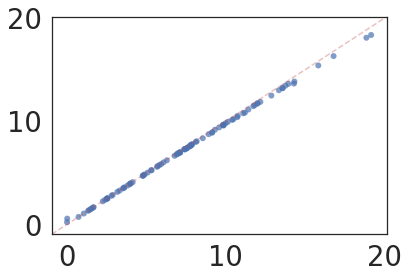

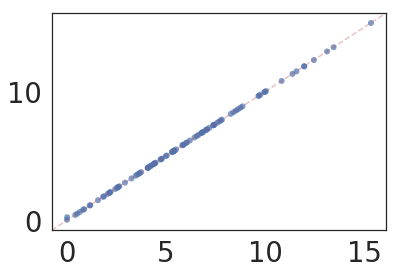

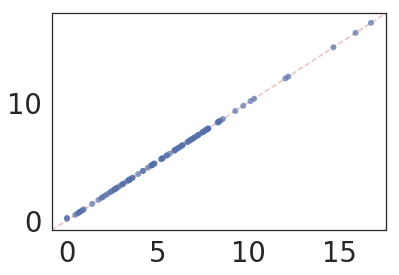

In [5]:
sns.set(font_scale=2.5)
it = 10
corr_plot(df50, df50, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/50_admm_10.pdf", bbox_inches='tight')
plt.show()
corr_plot(df100, df100, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/100_admm_10.pdf", bbox_inches='tight')
plt.show()
corr_plot(df200, df200, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/200_admm_10.pdf", bbox_inches='tight')
plt.show()

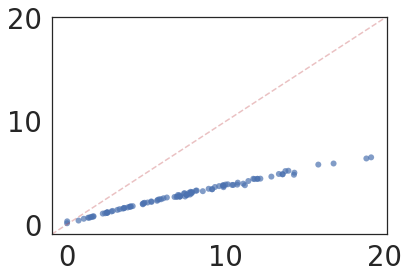

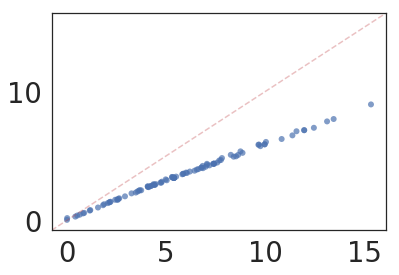

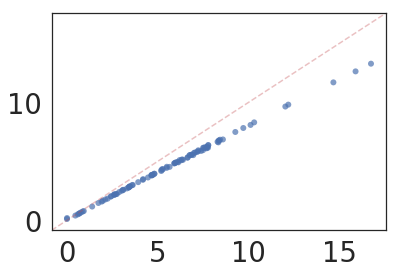

In [6]:
sns.set(font_scale=2.5)
it = 1
corr_plot(df50, df50, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/50_admm_1.pdf", bbox_inches='tight')
plt.show()
corr_plot(df100, df100, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/100_admm_1.pdf", bbox_inches='tight')
plt.show()
corr_plot(df200, df200, "cPval", "", "", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/200_admm_1.pdf", bbox_inches='tight')
plt.show()

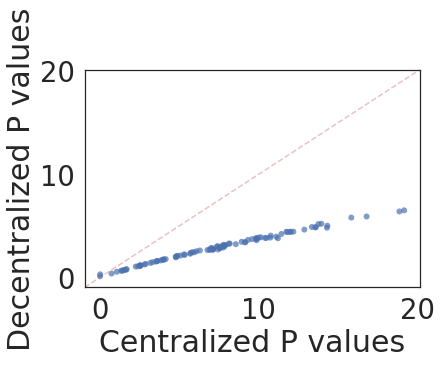

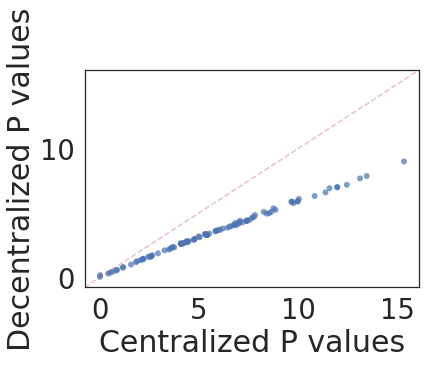

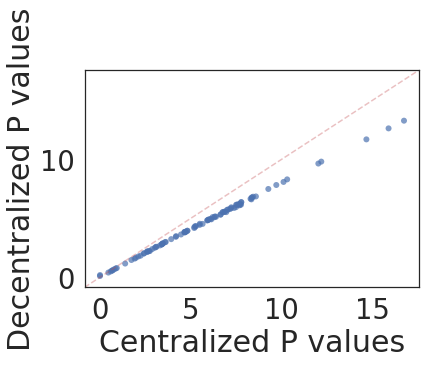

In [7]:
sns.set(font_scale=2.5)
it = 1
corr_plot(df50, df50, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/50_admm_1.pdf", bbox_inches='tight')
plt.show()
corr_plot(df100, df100, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/100_admm_1.pdf", bbox_inches='tight')
plt.show()
corr_plot(df200, df200, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=it)
fig = plt.gcf()
plt.savefig("../figures/200_admm_1.pdf", bbox_inches='tight')
plt.show()

In [8]:
dfDiff = pd.DataFrame()
dfDiff["50 meta"] = df50.cPval - df50.mPval
dfDiff["50 ADMM"] = df50.cPval - df50.dPval
dfDiff["100 meta"] = df100.cPval - df100.mPval
dfDiff["100 ADMM"] = df100.cPval - df100.dPval
dfDiff["200 meta"] = df200.cPval - df200.mPval
dfDiff["200 ADMM"] = df200.cPval - df200.dPval
dfDiff["300 meta"] = df300.cPval - df300.mPval
dfDiff["300 ADMM"] = df300.cPval - df300.dPval
dfDiff["400 meta"] = df400.cPval - df400.mPval
dfDiff["400 ADMM"] = df400.cPval - df400.dPval
dfDiff["500 meta"] = df500.cPval - df500.mPval
dfDiff["500 ADMM"] = df500.cPval - df500.dPval
dfDiff["iters"]    = df50.iter

/home/apoursh/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


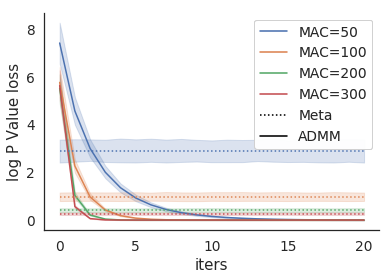

In [9]:
sns.set(font_scale=1.25)
sns.set_style("white")
dfDiff = dfDiff[dfDiff.iters < 21]

colors = sns.color_palette()

ax = sns.lineplot(data=dfDiff, x="iters", y="50 ADMM", color=colors[0], label="50")
ax = sns.lineplot(data=dfDiff, x="iters", y="100 ADMM", color=colors[1], ax=ax, label="100")
ax = sns.lineplot(data=dfDiff, x="iters", y="200 ADMM", color=colors[2], ax=ax, label="200 ADMM")
ax = sns.lineplot(data=dfDiff, x="iters", y="300 ADMM", color=colors[3], ax=ax)
ax = sns.lineplot(data=dfDiff, x="iters", y="50 meta", color=colors[0], ax=ax)
sns.lineplot(data=dfDiff, x="iters", y="100 meta", color=colors[1], ax=ax, label="100 ADMM")
sns.lineplot(data=dfDiff, x="iters", y="200 meta", color=colors[2], ax=ax, label="200 ADMM")
ax = sns.lineplot(data=dfDiff, x="iters", y="300 meta", color=colors[3], ax=ax)
[ax.lines[i].set_linestyle("dotted") for i in range(4,8)] # Set line style 
ax.set_xlabel("iters")
ax.set_ylabel("log P Value loss")
handles, labels = ax.get_legend_handles_labels()
lines = ax.get_lines()

dummy_lines = []
dummy_lines.append(ax.plot([],[], c="black", ls = "dotted")[0])
dummy_lines.append(ax.plot([],[], c="black")[0])
legend1 = plt.legend([lines[i] for i in range(4)] + [dummy_lines[i] for i in [0,1]]
                     , ["MAC=50", "MAC=100", "MAC=200", "MAC=300", "Meta", "ADMM"], loc=1)

ax.add_artist(legend1)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save the plot
plt.savefig("../figures/P_valLoss.pdf", bbox_inches='tight')
plt.show()

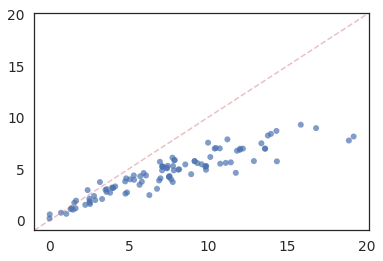

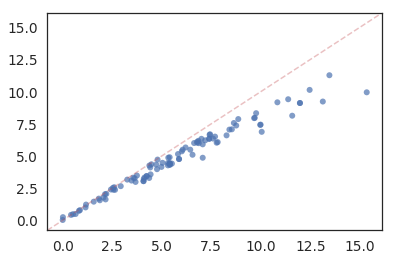

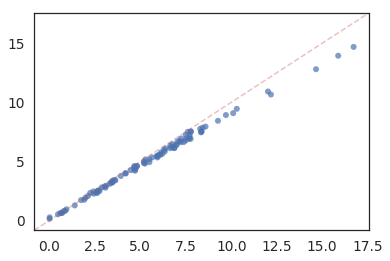

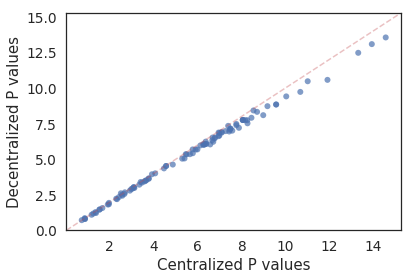

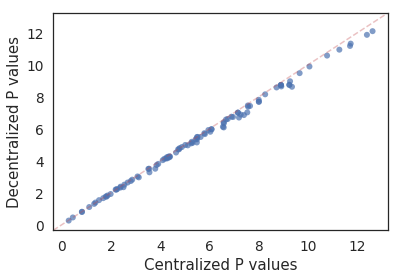

In [10]:
corr_plot(df50, df50, "cPval", "", "", var2="mPval", restriction="iter", r_val=1)
fig = plt.gcf()
plt.savefig("../figures/50_m.pdf", bbox_inches='tight')
plt.show()
corr_plot(df100, df100, "cPval", "", "", var2="mPval", restriction="iter", r_val=1)
fig = plt.gcf()
plt.savefig("../figures/100_m.pdf", bbox_inches='tight')
plt.show()
corr_plot(df200, df200, "cPval", "", "", var2="mPval", restriction="iter", r_val=1)
fig = plt.gcf()
plt.savefig("../figures/200_m.pdf", bbox_inches='tight')
plt.show()
corr_plot(df300, df300, "cPval", "Centralized P values", "Decentralized P values", var2="mPval", restriction="iter", r_val=1)
fig = plt.gcf()
plt.show()
corr_plot(df500, df500, "cPval", "Centralized P values", "Decentralized P values", var2="mPval", restriction="iter", r_val=1)
fig = plt.gcf()
plt.show()

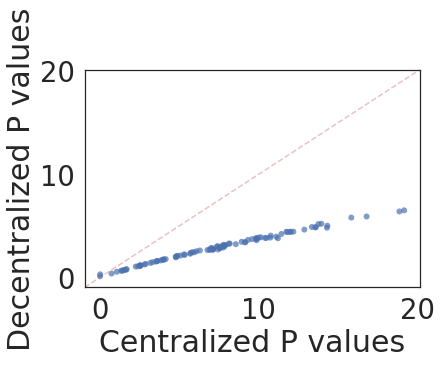

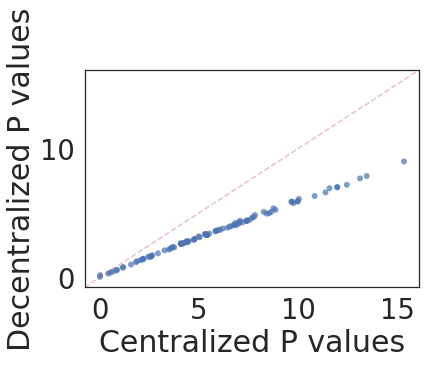

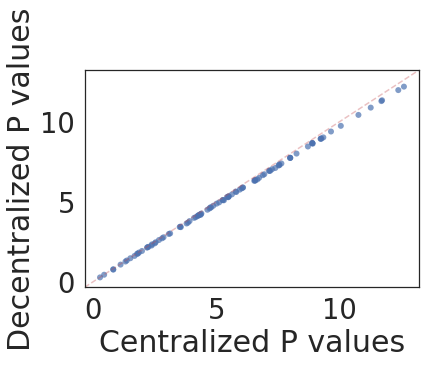

In [11]:
sns.set(font_scale=2.5)
iterNumber = 1
corr_plot(df50, df50, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=iterNumber)
fig = plt.gcf()
plt.show()
corr_plot(df100, df100, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=iterNumber)
fig = plt.gcf()
plt.show()
corr_plot(df500, df500, "cPval", "Centralized P values", "Decentralized P values", var2="dPval", restriction="iter", r_val=iterNumber)
fig = plt.gcf()
plt.show()